In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
path='C:\\Users\\Administrator\\Desktop\\pic1.png'
path2='C:\\Users\\Administrator\\Desktop\\pic2.png'
import numpy as np
import pywt
import pywt.data

In [2]:
def show(pic1,pic2):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(pic1)
    plt.subplot(1,2,2)
    plt.imshow(pic2)
    plt.show()

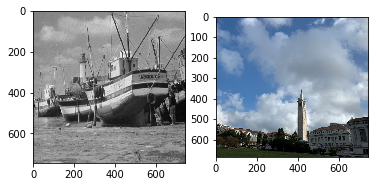

In [3]:
pic=cv2.imread(path)
pic2=cv2.imread(path2)
pic2=pic2[:,:,[-1,-2,-3]] #gbr -> rgb
show(pic,pic2)

# Spatial Domain 
## Histogram Enhancement

In [4]:
gray=cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
dst=cv2.equalizeHist(gray)
dst=cv2.cvtColor(dst,cv2.COLOR_GRAY2BGR)

In [5]:
pic2_r=pic2[:,:,0]
pic2_g=pic2[:,:,1]
pic2_b=pic2[:,:,2]
dst_pic2_r=cv2.equalizeHist(pic2_r)
dst_pic2_g=cv2.equalizeHist(pic2_g)
dst_pic2_b=cv2.equalizeHist(pic2_b)
dst_pic2=np.stack((dst_pic2_r,dst_pic2_g,dst_pic2_b),axis=-1)

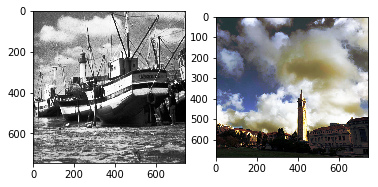

In [6]:
show(dst,dst_pic2)

# Spatial Domain
## Laplacian Enhancement

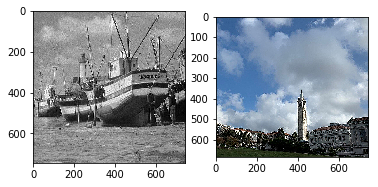

In [7]:
kernel=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
lap1=cv2.filter2D(pic,-1,kernel)
lap2=cv2.filter2D(pic2,-1,kernel)
show(lap1,lap2)


# Gauss filtering

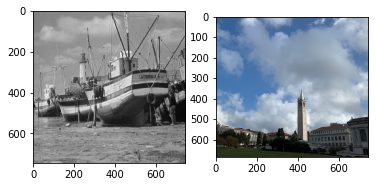

In [8]:
gs1=cv2.GaussianBlur(pic,(5,5),100)
gs2=cv2.GaussianBlur(pic2,(5,5),100)
show(gs1,gs2)

# Log Laplace Of Gauss

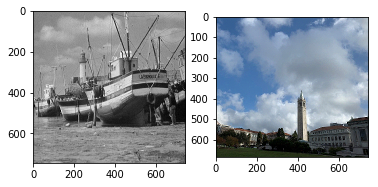

In [9]:
kernel=np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
log1=cv2.filter2D(gs1,-1,kernel)
log2=cv2.filter2D(gs2,-1,kernel)
show(log1,log2)

# Retinex SSR/MSR

In [10]:
def ssr(pic,sigma):
    temp=cv2.GaussianBlur(pic,(0,0),sigma)
    gaussian=np.where(temp == 0, 0.01, temp)
    retinex=np.log10(pic+0.01)-np.log10(gaussian)
    retinex=np.power(10,retinex)
    cap=retinex.max()-retinex.min()
    retinex=retinex-retinex.min()
    retinex=retinex* (255./cap)
    retinex=retinex.astype(np.uint8)
    return retinex

In [11]:
result=ssr(pic2,80)
max=result.max()
min=result.min()
cap=max-min

In [12]:
result=result-result.min()
dis=255./cap
result=result*dis

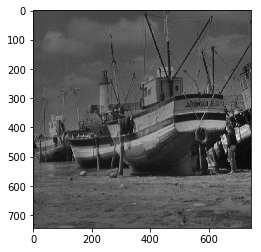

In [13]:
temp=ssr(pic,100)
plt.imshow(temp,'gray')

### MSR

In [14]:
retinex1=ssr(pic,15)
retinex2=ssr(pic,80)
retinex3=ssr(pic,200)

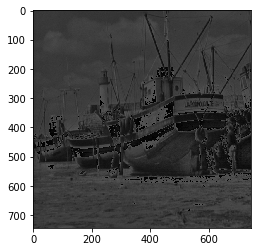

In [15]:
result1=np.zeros_like(retinex1)
result1=(retinex1+retinex2+retinex3)/3.0
result1=result1.astype(np.uint8)
plt.imshow(result1)

# Frequency domain transformation

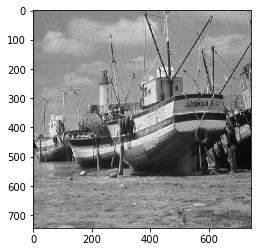

In [16]:
plt.imshow(pic[:,:,0],'gray')
f=np.fft.fft2(pic[:,:,0])
fshift=np.fft.fftshift(f)

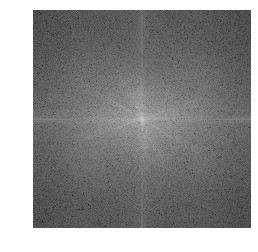

In [17]:
s1=np.log(np.abs(fshift))
plt.axis('off')
plt.imshow(s1,'gray')

## Ideal Low Pass Filter

In [18]:
def make_transform_matrix(d,image):
    transfor_matrix = np.zeros(image.shape)
    center_point = tuple(map(lambda x:(x-1)/2,s1.shape))
    for i in range(transfor_matrix.shape[0]):
        for j in range(transfor_matrix.shape[1]):
            def cal_distance(pa,pb):
                from math import sqrt
                dis = sqrt((pa[0]-pb[0])**2+(pa[1]-pb[1])**2)
                return dis
            dis = cal_distance(center_point,(i,j))
            if dis <= d:
                transfor_matrix[i,j]=1
            else:
                transfor_matrix[i,j]=0
    return transfor_matrix

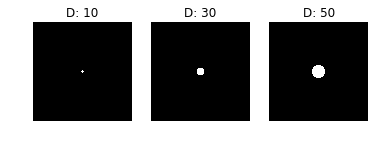

In [19]:
d_1 = make_transform_matrix(10,fshift)
d_2 = make_transform_matrix(30,fshift)
d_3 = make_transform_matrix(50,fshift)
plt.subplot(131)
plt.axis("off")
plt.imshow(d_1,cmap="gray")
plt.title('D: 10')
plt.subplot(132)
plt.axis("off")
plt.title('D: 30')
plt.imshow(d_2,cmap="gray")
plt.subplot(133)
plt.axis("off")
plt.title("D: 50")
plt.imshow(d_3,cmap="gray")
plt.show()

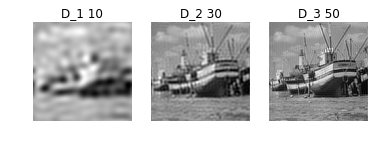

In [20]:
img_d1 = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift*d_1)))
img_d2 = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift*d_2)))
img_d3 = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift*d_3)))
plt.subplot(131)
plt.axis("off")
plt.imshow(img_d1,cmap="gray")
plt.title('D_1 10')
plt.subplot(132)
plt.axis("off")
plt.title('D_2 30')
plt.imshow(img_d2,cmap="gray")
plt.subplot(133)
plt.axis("off")
plt.title("D_3 50")
plt.imshow(img_d3,cmap="gray")
plt.show()


## Gauss Low Pass Filter

In [21]:
def GaussianLowFilter(image,d):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    def make_transform_matrix(d):
        transfor_matrix = np.zeros(image.shape)
        center_point = tuple(map(lambda x:(x-1)/2,s1.shape))
        for i in range(transfor_matrix.shape[0]):
            for j in range(transfor_matrix.shape[1]):
                def cal_distance(pa,pb):
                    from math import sqrt
                    dis = sqrt((pa[0]-pb[0])**2+(pa[1]-pb[1])**2)
                    return dis
                dis = cal_distance(center_point,(i,j))
                transfor_matrix[i,j] = np.exp(-(dis**2)/(2*(d**2)))
        return transfor_matrix
    d_matrix = make_transform_matrix(d)
    new_img = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift*d_matrix)))
    return new_img

In [22]:
def make_transform_matrix(image,d):
        transfor_matrix = np.zeros(image.shape)
        center_point = tuple(map(lambda x:(x-1)/2,s1.shape))
        for i in range(transfor_matrix.shape[0]):
            for j in range(transfor_matrix.shape[1]):
                def cal_distance(pa,pb):
                    from math import sqrt
                    dis = sqrt((pa[0]-pb[0])**2+(pa[1]-pb[1])**2)
                    return dis
                dis = cal_distance(center_point,(i,j))
                transfor_matrix[i,j] = np.exp(-(dis**2)/(2*(d**2)))
        return transfor_matrix

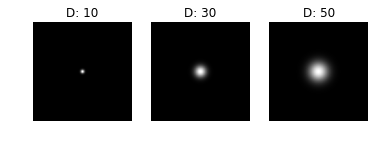

In [23]:
d_1=make_transform_matrix(pic[:,:,0],10)
d_2=make_transform_matrix(pic[:,:,0],30)
d_3=make_transform_matrix(pic[:,:,0],50)
plt.subplot(131)
plt.axis("off")
plt.imshow(d_1,cmap="gray")
plt.title('D: 10')
plt.subplot(132)
plt.axis("off")
plt.title('D: 30')
plt.imshow(d_2,cmap="gray")
plt.subplot(133)
plt.axis("off")
plt.title("D: 50")
plt.imshow(d_3,cmap="gray")
plt.show()

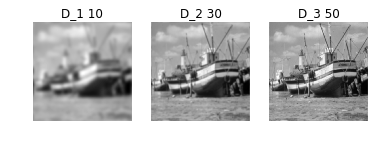

In [24]:
img_d1 = GaussianLowFilter(pic[:,:,0],10)
img_d2 = GaussianLowFilter(pic[:,:,0],30)
img_d3 = GaussianLowFilter(pic[:,:,0],50)
plt.subplot(131)
plt.axis("off")
plt.imshow(img_d1,cmap="gray")
plt.title('D_1 10')
plt.subplot(132)
plt.axis("off")
plt.title('D_2 30')
plt.imshow(img_d2,cmap="gray")
plt.subplot(133)
plt.axis("off")
plt.title("D_3 50")
plt.imshow(img_d3,cmap="gray")
plt.show()

## Butterworth Low Pass Filter

In [25]:
   def make_transform_matrix(image,d,n):
        n=n*2
        transfor_matrix = np.zeros(image.shape)
        center_point = tuple(map(lambda x:(x-1)/2,image.shape))
        for i in range(transfor_matrix.shape[0]):
            for j in range(transfor_matrix.shape[1]):
                def cal_distance(pa,pb):
                    from math import sqrt
                    dis = sqrt((pa[0]-pb[0])**2+(pa[1]-pb[1])**2)
                    return dis
                dis = cal_distance(center_point,(i,j))
                transfor_matrix[i,j] = 1/((1+(dis/d))**n)
        return transfor_matrix

In [26]:
def butterworthPassFilter(image,d,n):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    n=n*2
    def make_transform_matrix(d):
        transfor_matrix = np.zeros(image.shape)
        center_point = tuple(map(lambda x:(x-1)/2,image.shape))
        for i in range(transfor_matrix.shape[0]):
            for j in range(transfor_matrix.shape[1]):
                def cal_distance(pa,pb):
                    from math import sqrt
                    dis = sqrt((pa[0]-pb[0])**2+(pa[1]-pb[1])**2)
                    return dis
                dis = cal_distance(center_point,(i,j))
                transfor_matrix[i,j] = 1/((1+(dis/d))**n)
        return transfor_matrix
    d_matrix = make_transform_matrix(d)
    new_img = np.abs(np.fft.ifft2(np.fft.ifftshift(fshift*d_matrix)))
    return new_img

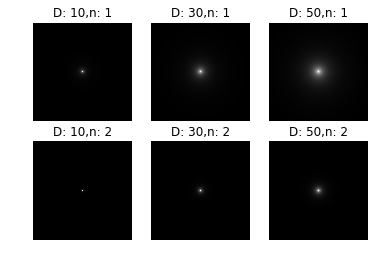

In [27]:
d_1=make_transform_matrix(pic[:,:,0],10,1)
d_2=make_transform_matrix(pic[:,:,0],30,1)
d_3=make_transform_matrix(pic[:,:,0],50,1)
d_4=make_transform_matrix(pic[:,:,0],10,2)
d_5=make_transform_matrix(pic[:,:,0],30,2)
d_6=make_transform_matrix(pic[:,:,0],50,2)
plt.subplot(231)
plt.axis("off")
plt.imshow(d_1,cmap="gray")
plt.title('D: 10,n: 1')
plt.subplot(232)
plt.axis("off")
plt.title('D: 30,n: 1')
plt.imshow(d_2,cmap="gray")
plt.subplot(233)
plt.axis("off")
plt.title("D: 50,n: 1")
plt.imshow(d_3,cmap="gray")
plt.subplot(234)
plt.axis("off")
plt.title("D: 10,n: 2")
plt.imshow(d_4,cmap="gray")
plt.subplot(235)
plt.axis("off")
plt.title("D: 30,n: 2")
plt.imshow(d_5,cmap="gray")
plt.subplot(236)
plt.axis("off")
plt.title("D: 50,n: 2")
plt.imshow(d_6,cmap="gray")
plt.show()

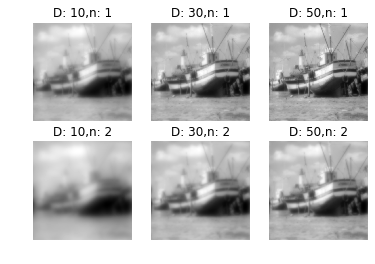

In [28]:
image1=butterworthPassFilter(pic[:,:,0],10,1)
image2=butterworthPassFilter(pic[:,:,0],30,1)
image3=butterworthPassFilter(pic[:,:,0],50,1)
image4=butterworthPassFilter(pic[:,:,0],10,2)
image5=butterworthPassFilter(pic[:,:,0],30,2)
image6=butterworthPassFilter(pic[:,:,0],50,2)
plt.subplot(231)
plt.axis("off")
plt.imshow(image1,cmap="gray")
plt.title('D: 10,n: 1')
plt.subplot(232)
plt.axis("off")
plt.title('D: 30,n: 1')
plt.imshow(image2,cmap="gray")
plt.subplot(233)
plt.axis("off")
plt.title("D: 50,n: 1")
plt.imshow(image3,cmap="gray")
plt.subplot(234)
plt.axis("off")
plt.title("D: 10,n: 2")
plt.imshow(image4,cmap="gray")
plt.subplot(235)
plt.axis("off")
plt.title("D: 30,n: 2")
plt.imshow(image5,cmap="gray")
plt.subplot(236)
plt.axis("off")
plt.title("D: 50,n: 2")
plt.imshow(image6,cmap="gray")
plt.show()